<a href="https://colab.research.google.com/github/Jeetesh1512/learnML/blob/main/breakhis_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall
import seaborn as sns
from PIL import Image

In [105]:
SEED=42
BATCH_SIZE=16

In [106]:
!pip install opendatasets --upgrade --quiet

In [107]:
import opendatasets as od

In [108]:
od.version()

'0.1.22'

In [109]:
dataset_url = 'https://www.kaggle.com/datasets/ambarish/breakhis'

In [110]:
od.download(dataset_url)

Skipping, found downloaded files in "./breakhis" (use force=True to force download)


In [111]:
base_path='/content/breakhis/BreaKHis_v1/'

In [112]:
folds = pd.read_csv('/content/breakhis/Folds.csv')

In [113]:
folds['grp'].value_counts()

,count
grp,
train,25880
test,13665


In [114]:
benign_classes = ['phyllodes_tumor', 'adenosis', 'fibroadenoma', 'tubular_adenoma']
malignant_classes = ['ductal_carcinoma', 'lobular_carcinoma', 'papillary_carcinoma', 'mucinous_carcinoma']

def get_labels(path):
    path_lower = path.lower()

    if 'benign' in path_lower:
        coarse_label = 'benign'
    else:
        coarse_label = 'malignant'

    fine_label = None
    for cls in benign_classes + malignant_classes:
        if cls in path_lower:
            fine_label = cls
            break

    return pd.Series([coarse_label, fine_label])

folds[['coarse_label', 'fine_label']] = folds['filename'].apply(get_labels)


In [115]:
folds['filename'] = folds['filename'].apply(lambda x: os.path.join(base_path, x))

In [116]:
folds.drop(columns=['fold','grp'], inplace=True)

In [117]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39545 entries, 0 to 39544
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   mag           39545 non-null  int64 
 1   filename      39545 non-null  object
 2   coarse_label  39545 non-null  object
 3   fine_label    39545 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [118]:
folds.head(8)

,mag,filename,coarse_label,fine_label
0,100,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,benign,adenosis
1,100,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,benign,adenosis
2,100,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,benign,adenosis
3,100,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,benign,adenosis
4,100,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,benign,adenosis
5,100,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,benign,adenosis
6,100,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,benign,adenosis
7,100,/content/breakhis/BreaKHis_v1/BreaKHis_v1/hist...,benign,adenosis


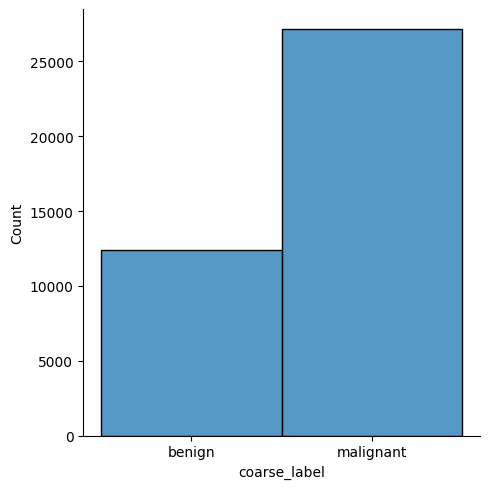

In [119]:
sns.displot(data=folds,x='coarse_label')

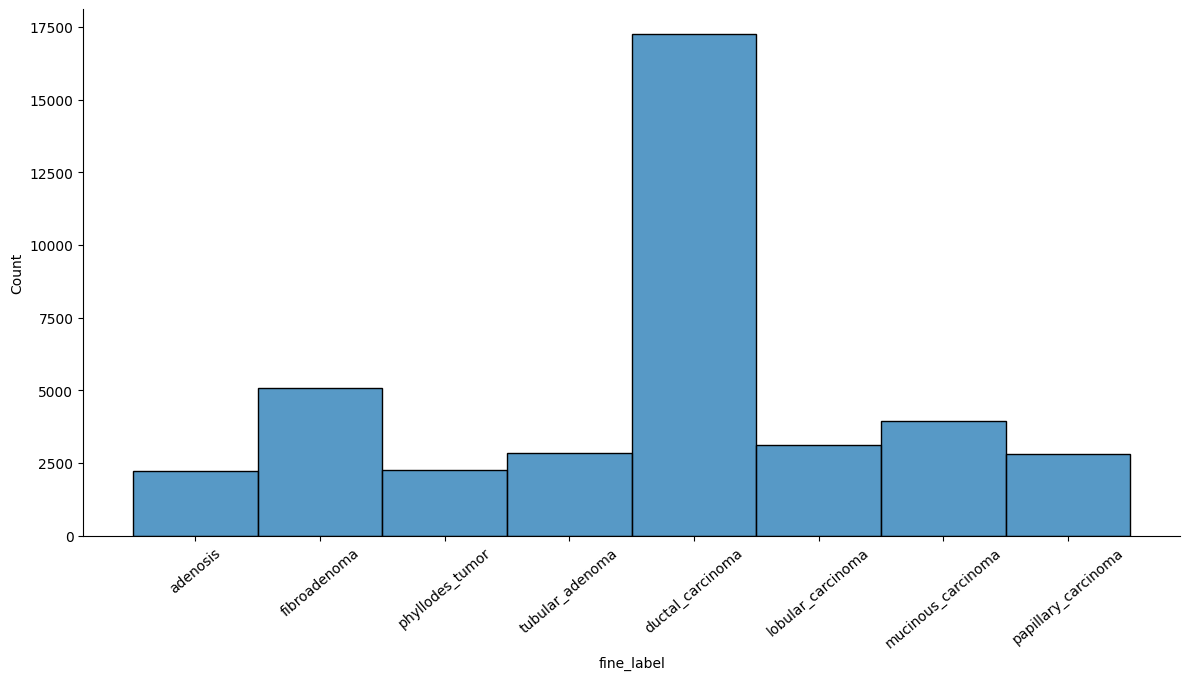

In [120]:
sns.displot(data=folds, x='fine_label', height=6, aspect=2)
plt.xticks(rotation=40)
plt.show()

In [121]:
test_df = folds.groupby('coarse_label',group_keys=False).sample(n=800,random_state=SEED)
train_df = folds.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print('Training Set:')
print(train_df['coarse_label'].value_counts())

print('Validation Set:')
print(valid_df['coarse_label'].value_counts())

print('Test Set:')
print(test_df['coarse_label'].value_counts())

Training Set:
coarse_label
malignant    21036
benign        9320
Name: count, dtype: int64
Validation Set:
coarse_label
malignant    5309
benign       2280
Name: count, dtype: int64
Test Set:
coarse_label
benign       800
malignant    800
Name: count, dtype: int64


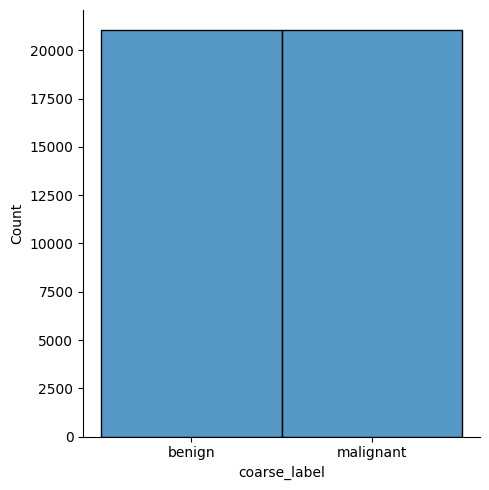

In [122]:
#upsampling
max_count = np.max(train_df.coarse_label.value_counts())
min_count = np.min(train_df.coarse_label.value_counts())
train_df = train_df.groupby('coarse_label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.coarse_label.value_counts()

sns.displot(data=train_df, x='coarse_label')

In [123]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [124]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='coarse_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col='coarse_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='coarse_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# train_subset = train_df.sample(frac=0.1, random_state=42)
# val_subset = valid_df.sample(frac=0.1, random_state=42)

# train_generator = train_datagen.flow_from_dataframe(
#     train_subset,
#     x_col='filename',
#     y_col='coarse_label',
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical'
# )

# val_generator = datagen.flow_from_dataframe(
#     val_subset,
#     x_col='filename',
#     y_col='coarse_label',
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical'
# )


Found 42072 validated image filenames belonging to 2 classes.
Found 7589 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


In [125]:
print(train_generator.image_shape)
print(val_generator.image_shape)
print(test_generator.image_shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


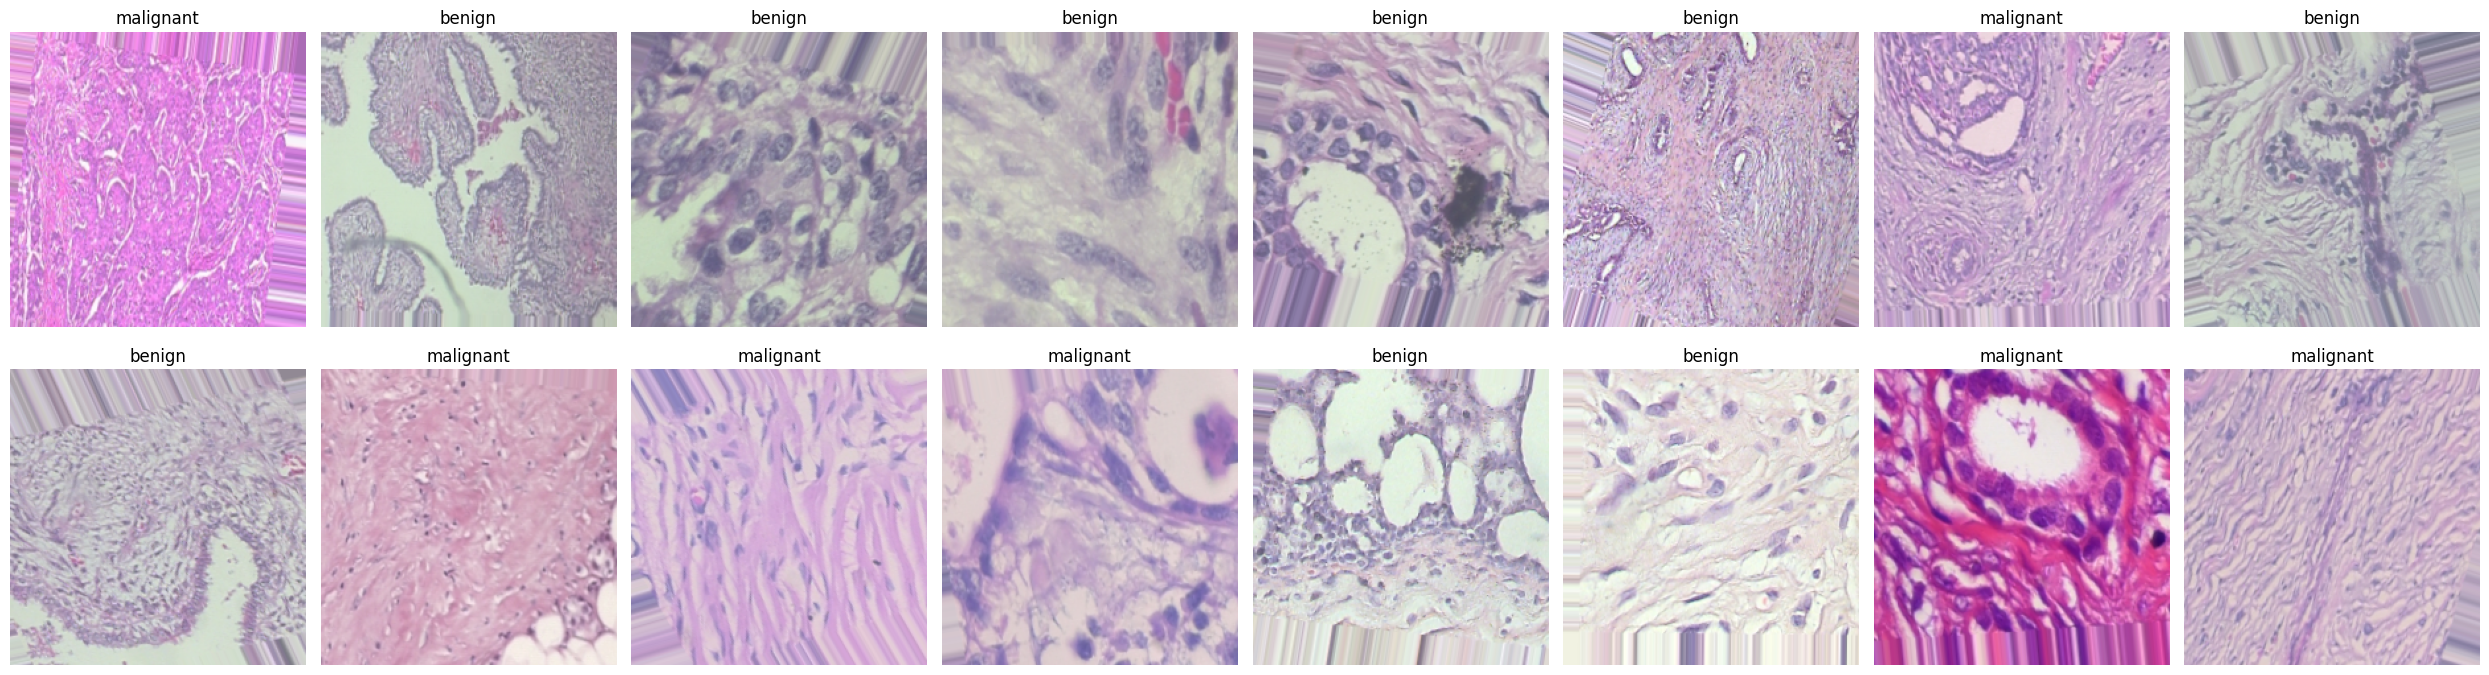

In [126]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ['benign', 'malignant']

def view_image(generator, col=8, row=2, size=(25, 7)):
    images, labels = next(generator)
    total = len(images)
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)

    for i in range(total):
        ax = plt.subplot(row, col, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


view_image(train_generator)

In [127]:
from tensorflow.keras import layers

class SimilarityLossLayer(layers.Layer):
    def __init__(self, lambda_sim=0.1, **kwargs):
        super().__init__(**kwargs)
        self.lambda_sim = lambda_sim

    def call(self, f1, f2):
        # Compute cosine similarity
        f1_norm = tf.nn.l2_normalize(f1, axis=-1)
        f2_norm = tf.nn.l2_normalize(f2, axis=-1)
        sim_loss = tf.reduce_mean(tf.square(f1_norm - f2_norm))
        self.add_loss(self.lambda_sim * sim_loss)
        return f1, f2

In [128]:
def triple_attention(f1, f2):
    # Channel Attention
    def channel_attention(x):
        avg_pool = layers.GlobalAveragePooling2D()(x)
        dense1 = layers.Dense(x.shape[-1] // 8, activation='relu')(avg_pool)
        dense2 = layers.Dense(x.shape[-1], activation='sigmoid')(dense1)
        scale = layers.Reshape((1, 1, x.shape[-1]))(dense2)
        return layers.Multiply()([x, scale])

    # Spatial Attention (fixed: use keras ops, not tf ops)
    def spatial_attention(x):
        avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
        max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
        concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
        attn = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
        return layers.Multiply()([x, attn])

    # Cross Attention
    def cross_attention(a, b):
        q = layers.Conv2D(a.shape[-1], 1, padding="same")(a)
        k = layers.Conv2D(b.shape[-1], 1, padding="same")(b)
        v = layers.Conv2D(b.shape[-1], 1, padding="same")(b)
        attn = layers.Activation('softmax')(layers.Multiply()([q, k]))
        return layers.Add()([a, layers.Multiply()([attn, v])])

    ca = channel_attention(f1)
    sa = spatial_attention(f1)
    xa = cross_attention(f1, f2)

    out = layers.Add()([ca, sa, xa])
    return out

In [129]:
def freeze_and_inspect(base_model, freeze_until=150, branch_name="Branch"):
    # Freeze layers
    for layer in base_model.layers[:freeze_until]:
        layer.trainable = False
    for layer in base_model.layers[freeze_until:]:
        layer.trainable = True

    for layer in base_model.layers:
      if isinstance(layer, BatchNormalization):
          layer.trainable = True
      else:
          continue

    #Print summary
    # print(f"\n{branch_name} — Trainable Layer Summary (Freeze until layer {freeze_until})")
    # print("------------------------------------------------------------")
    # print(f"{'Layer Name':40s} | {'Trainable'}")
    # print("-" * 55)
    # for i, layer in enumerate(base_model.layers):
    #     print(f"{i:3d}: {layer.name:40s} | {layer.trainable}")
    # print(f"Total layers: {len(base_model.layers)}")
    # print(f"Trainable layers: {np.sum([l.trainable for l in base_model.layers])}")
    # print(f"Non-trainable layers: {np.sum([not l.trainable for l in base_model.layers])}")


In [130]:
from tensorflow.keras import optimizers
from keras import Sequential, Model, backend as K
from keras.layers import Dense, Input , Flatten, Conv2D, UpSampling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0


def build_dual_branch_model(input_shape=(224, 224, 3), num_classes=2, lambda_sim=0.1):
    inputs = layers.Input(shape=input_shape)

    # --- Branch 1 ---
    base1 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    freeze_and_inspect(base1, freeze_until=78, branch_name="EffNetB0_Branch1")

    mid1 = base1.get_layer("block4a_expand_activation").output
    out1 = base1.output
    branch1_model = models.Model(base1.input, [mid1, out1], name="EffNetB0_Branch1")
    mid1_map, f1_map = branch1_model(inputs)

    # --- Branch 2 ---
    base2 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    freeze_and_inspect(base2, freeze_until=78, branch_name="EffNetB0_Branch2")

    mid2 = base2.get_layer("block4a_expand_activation").output
    out2 = base2.output
    branch2_model = models.Model(base2.input, [mid2, out2], name="EffNetB0_Branch2")
    mid2_map, f2_map = branch2_model(inputs)

    # --- Triple Attention in the middle ---
    ta_mid1 = triple_attention(mid1_map, mid2_map)
    ta_mid2 = triple_attention(mid2_map, mid1_map)

    # --- Combine mid and high-level features ---
    mid_fused = layers.Concatenate()([
        layers.GlobalAveragePooling2D()(ta_mid1),
        layers.GlobalAveragePooling2D()(ta_mid2)
    ])

    # --- High-level features ---
    f1 = layers.GlobalAveragePooling2D()(f1_map)
    f2 = layers.GlobalAveragePooling2D()(f2_map)

    # --- Similarity Regularization ---
    f1, f2 = SimilarityLossLayer(lambda_sim)(f1, f2)

    # --- Fuse all ---
    fused = layers.Concatenate()([mid_fused, f1, f2])
    fused = layers.Dense(512, activation='gelu')(fused)
    fused = layers.BatchNormalization()(fused)
    fused = layers.Dropout(0.4)(fused)

    fused = layers.Dense(256, activation='gelu')(fused)
    fused = layers.BatchNormalization()(fused)
    fused = layers.Dropout(0.3)(fused)

    outputs = layers.Dense(num_classes, activation='softmax')(fused)

    # --- Final Model ---
    model = models.Model(inputs, outputs, name='DualBranch_with_MidTripleAttention')
    model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
      ]
    )
    return model

In [131]:
tf.keras.backend.clear_session()
model = build_dual_branch_model()
model.summary()

Model: "DualBranch_with_MidTripleAttention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EffNetB0_Branch1    │ [(None, 28, 28,   │  4,049,571 │ input_layer[0][0] │
│ (Functional)        │ 240), (None, 7,   │            │                   │
│                     │ 7, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EffNetB0_Branch2    │ [(None, 28, 28,   │  4,049,571 │ input_layer[0][0] │
│ (Functional)        │ 240), (None, 7,   │            │                   │
│                     │ 7, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 240)       │          0 │ EffNetB0_Branch1… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     57,840 │ EffNetB0_Branch1… │
│                     │ 240)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     57,840 │ EffNetB0_Branch2… │
│                     │ 240)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 240)       │          0 │ EffNetB0_Branch2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     57,840 │ EffNetB0_Branch2… │
│                     │ 240)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     57,840 │ EffNetB0_Branch1… │
│                     │ 240)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │      7,230 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 28, 28, 1) │          0 │ EffNetB0_Branch1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 28, 28, 1) │          0 │ EffNetB0_Branch1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 28, 28,    │          0 │ conv2d_1[0][0],   │
│ (Multiply)          │ 240)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30)        │      7,230 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 28, 28, 1) │          0 │ EffNetB0_Branch2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 28, 28, 1) │          0 │ EffNetB0_Branch2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 28, 28,    │          0 │ conv2d_5[0][0],   │
│ (Multiply)          │ 240)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 240)       │      7,440 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 10,167,626 (38.79 MB)

 Trainable params: 9,937,208 (37.91 MB)

 Non-trainable params: 230,418 (900.08 KB)

In [132]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Simple CNN model
# model = Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D(2,2),

#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(2,2),

#     Flatten(),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dense(2, activation='softmax')  # 2 classes: benign, malignant
# ])

# # Compile model
# model.compile(
#     optimizer=Adam(learning_rate=1e-3),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

In [133]:
batch_x, batch_y = next(iter(train_generator))
print(batch_x.shape, batch_y.shape)

(16, 224, 224, 3) (16, 2)


In [134]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    '/kaggle/working/model_epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

In [135]:
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=10,
#     batch_size=BATCH_SIZE,
#     callbacks=[checkpoint,early_stop],
#     verbose=1
# )

In [136]:
model.load_weights('/content/model_epoch_16_valacc_0.9971.weights.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 770 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [137]:
loss, accuracy,auc,precision,recall = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 245ms/step - accuracy: 0.9990 - auc: 1.0000 - loss: 0.0062 - precision: 0.9990 - recall: 0.9990
Test Loss: 0.0080
Test Accuracy: 99.87%
Test Precision: 99.87%
Test Recall: 99.99%


In [138]:
def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

In [139]:
# plot_history(history)

100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step


<Figure size 800x800 with 0 Axes>

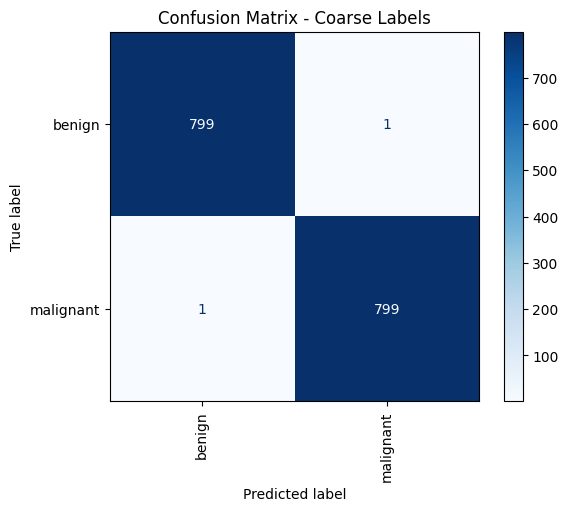

In [140]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 1. Predict labels for test set
# -------------------------------
y_pred_probs = model.predict(test_generator)       # predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)           # predicted class indices
y_true = test_generator.classes                    # true class indices

# -------------------------------
# 2. Compute confusion matrix
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

# -------------------------------
# 3. Display confusion matrix
# -------------------------------
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(test_generator.class_indices.keys())
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix - Coarse Labels")
plt.show()